In [0]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from sklearn.metrics import accuracy_score
from keras import backend as K

from collections import namedtuple # named tuples for better readability

### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

In [0]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
del y_train, y_test

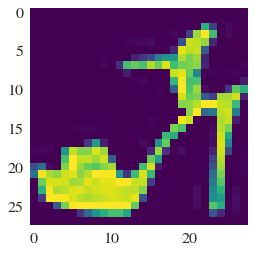

In [28]:
plt.imshow(X_train[9].reshape([28,28]))

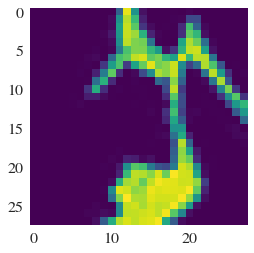

In [29]:
plt.imshow(transform.rotate(X_train[9].reshape([28,28]), 45))

### Задание.
Ваша задача - определить, при каком минимальном угле поворота нейронная сеть фиксированной архитектуры перестает различать обычное и повертнутое изображение. Говоря формально, решаем задачу классификации, исходные изображения принадлежат классу `0`, повернутые - классу `1`. Оцените точность классификации по метрике `accuracy` и ее дисперсию в зависимости от угла поворота изображения и отобразите данную зависимость на графике.

Функция `rotate_dataset` поворачивает поданный датасет на заданный угол. Функция `reset_weights` сбрасывает параметры модели.

*Обращаем ваше внимание, что для качественной оценки данных зависимостей эксперименты для каждого размера выборки стоит повторять многократно на различных случайных подвыборках.*

# Выполнение задания

Для начала определим необходимые функции по вращению датасета, получению новых пар объект-ответ, сброса параметров модели.

In [0]:
def rotate_dataset(dataset, angle):
    return np.array(list(map(lambda x: transform.rotate(x, angle), dataset)))

In [0]:
def get_X_and_y(base_dataset, angle):
    rotated_datased = rotate_dataset(base_dataset, angle)
    whole_dataset = np.vstack((base_dataset, rotated_datased)).reshape(-1, 784)
    shuffled_indices = np.arange(len(whole_dataset))
    
    _labels = np.zeros(2*base_dataset.shape[0], dtype=bool)
    _labels[base_dataset.shape[0]:] = True
    _labels = _labels[:, None]
    
    whole_labels = np.array(np.hstack((_labels, ~_labels)), dtype=int)
    
    np.random.shuffle(shuffled_indices)    
    whole_dataset = whole_dataset[shuffled_indices]
    whole_labels = whole_labels[shuffled_indices]
    
    return whole_dataset, whole_labels


In [0]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    return

## Строим архитектуру модели 
с помощью фреймворка Keras и бэк-энда Tensorflow. Поскольку функция `reset_weights` показала себя несколько неправильным образом, пришлось сделать такой костыль.

In [0]:
def reinit_model():
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer([784]))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(2))
    model.add(keras.layers.Activation('softmax'))
    model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
    return model

## Начинаем собирать данные для оценки точности модели

Для каждого угла `angle` делаем `n_runs` подвыборок из датасета размером `set_size`, на которых обучим модель и протестируем качество на тестах, аккумулируем данные и усредняем качество.


In [37]:
# Для сохранения результатов
import pickle

# Создадим кортежи для сохранения результатов
AngleTuple = namedtuple('AngleTuple', ['angle', 'mean', 'std'])

# Инициализируем гиперпараметры
n_runs = 7
n_epochs = 40
batch_size = 128
angle_step = 15
set_sizes = [500, 2000, 10000]

# Инициализируем хранилище результатов
total_scores = list()

for subset_size in set_sizes:
    subset_scores = list()

    for angle in range(0, 361, angle_step):

        # Получим тестовый датасет для конкретного угла
        X_test_whole, y_test_whole = get_X_and_y(X_test, angle)
  
        # Локальные результаты для конкретного угла
        angle_scores = list()
        
        for n_run in range(n_runs):
                    

            print('Subset size: {:>5} | angle: {:>3} | run {}/{}'.format(
                subset_size, angle, n_run + 1, n_runs), end='')
                   
            # Получим случайную подвыборку из обучающей для конкретного угла.
            # Делаем каждый раз новую случайную выборку, ибо рекомендация в 
            # задании (для качественной оценки модели)
            base_indices = np.random.choice(
                np.arange(X_train.shape[0]), size=subset_size, replace=False)
            base_dataset = X_train[base_indices]
            X, y = get_X_and_y(base_dataset, angle)

            # Реинициализируем модель и заново обучим её
            model = reinit_model()
            model.fit(X, y, batch_size=batch_size, epochs=n_epochs, verbose=0)

            # С помощью обученной модели сделаем предсказания на всей тестовой
            # выборке для данного угла
            y_test_predicted_whole = model.predict_classes(X_test_whole)
            run_acc = accuracy_score(y_test_whole[:, 1], y_test_predicted_whole)
            angle_scores.append(run_acc)

            print(' | acc: {}'.format(run_acc))
            
        # Результаты сохраняем
        subset_scores.append([angle, np.mean(angle_scores), np.std(angle_scores)])
        
    
    # Для надёжности, сохраним результаты для каждого размера
    # подвыборки в файлы
    
    with open('subset_{}_scores'.format(subset_size), 'wb') as f:
        pickle.dump(subset_scores, f)
    
    total_scores.append([subset_size, subset_scores])
    


Subset size:   500 | angle:   0 | run 1/7 | acc: 0.98815
Subset size:   500 | angle:   0 | run 2/7 | acc: 0.5
Subset size:   500 | angle:   0 | run 3/7 | acc: 0.5
Subset size:   500 | angle:   0 | run 4/7 | acc: 0.9989
Subset size:   500 | angle:   0 | run 5/7 | acc: 0.99285
Subset size:   500 | angle:   0 | run 6/7 | acc: 0.99925
Subset size:   500 | angle:   0 | run 7/7 | acc: 0.5
Subset size:   500 | angle:  15 | run 1/7 | acc: 0.9779
Subset size:   500 | angle:  15 | run 2/7 | acc: 0.997
Subset size:   500 | angle:  15 | run 3/7 | acc: 0.97215
Subset size:   500 | angle:  15 | run 4/7 | acc: 0.9986
Subset size:   500 | angle:  15 | run 5/7 | acc: 0.74335
Subset size:   500 | angle:  15 | run 6/7 | acc: 0.99855
Subset size:   500 | angle:  15 | run 7/7 | acc: 0.5
Subset size:   500 | angle:  30 | run 1/7 | acc: 0.58615
Subset size:   500 | angle:  30 | run 2/7 | acc: 0.9714
Subset size:   500 | angle:  30 | run 3/7 | acc: 0.94965
Subset size:   500 | angle:  30 | run 4/7 | acc: 0.96

In [0]:
# На случай проблем с соединением с Collaboratory, сохраним результаты на диск
with open('total_scores.pickle', 'wb') as f:
    pickle.dump(total_scores, f)


In [0]:
from google.colab import files
files.download('total_scores.pickle')

for subset_size in set_sizes:
    files.download('subset_{}_scores'.format(subset_size))

## Анализ результатов

Во время обучения заметил, что на некоторых подвыборках модель показала себя слишком плохо - вероятность правильного предсказания падала до 0.5. Но для большей наглядности, стоит построить графики и увидеть поведение оценочной функции вживую.

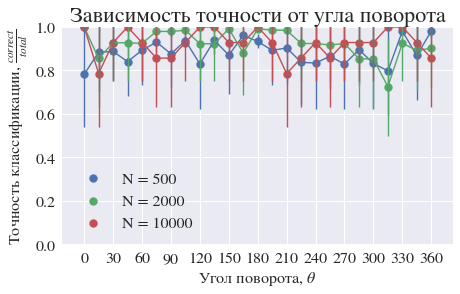

In [111]:
# Загружаем результаты из сохраненного файла
# with open('total_scores.pickle', 'rb') as f:
#   total_scores = pickle.load(f)


# Настраиваем параметры дизайна графика
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['lines.linewidth'] = 1.4
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


# Строим сам график
fig, ax = plt.subplots(1, 1)
ax.set_title('Зависимость точности от угла поворота')
ax.set_xlabel(r'Угол поворота, $\theta$')
ax.set_ylabel(r'Точность классификации, $\frac{correct}{total}$')

for N, scores in total_scores:
    scores = np.array(scores)
    ax.scatter(scores[:, 0], scores[:, 1], label=f'N = {N}')
    ax.errorbar(scores[:, 0], scores[:, 1], yerr=scores[:, 2], 
                capsize=5, barsabove=True)
ax.set_xticks(np.arange(0, 361, 30))
ax.set_ylim(0, 1)
ax.grid()
ax.legend()
plt.show()

# Сохранение изображения
plt.savefig('accuracy.png')

По этому графику может быть понятно, что в целом поворот мало на что влияет. Посмотрим, на каких углах были наибольшие ошибки для всех выборок в среднем.

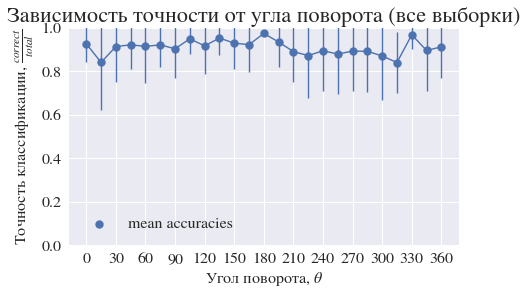

Min accuracy:  0.8411857142857143 on angle 315.0
Max std error: 0.21686010744018314 on angle 15.0


In [114]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Зависимость точности от угла поворота (все выборки)')
ax.set_xlabel(r'Угол поворота, $\theta$')
ax.set_ylabel(r'Точность классификации, $\frac{correct}{total}$')

just_scores = list()

for N in total_scores: 
    just_scores.append(N[1][:])
    
means = np.mean(just_scores, axis=0)

angles = means[:, 0]
accuracies = means[:, 1]
errors = means[:, 2]

ax.scatter(angles, accuracies, label='mean accuracies')
ax.errorbar(angles, accuracies, yerr=errors, 
            capsize=5, barsabove=True)
ax.set_xticks(np.arange(0, 361, 30))
ax.set_ylim(0, 1)
ax.grid()
ax.legend()
plt.show()

# Сохранение изображения
plt.savefig('mean_accuracy.png')

print(f'Min accuracy:  {np.min(accuracies)} on angle {angles[np.argmin(accuracies)]}')
print(f'Max std error: {np.max(errors)} on angle {angles[np.argmax(errors)]}')

Видим, что минимальная точность была в среднем достигнута на повороте на угол в 315º. Минимальное среднеквадратичное отклонение было достигнуто при повороте на угол 15º. 

Построим график зависимости среднеквадратичной ошибки в зависимости от размера выборки.

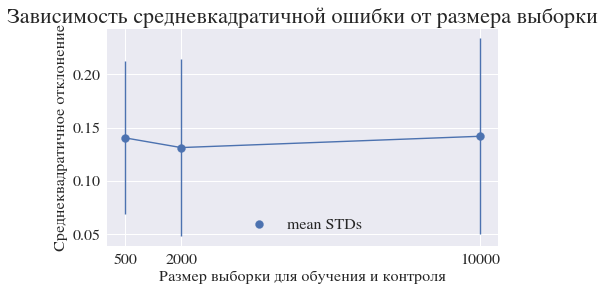

Min STD:       0.13134553290672166 on subset_size 2000
Max STD error: 0.09171753187903268 on subset_size 10000


In [115]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Зависимость средневкадратичной ошибки от размера выборки')
ax.set_xlabel(r'Размер выборки для обучения и контроля')
ax.set_ylabel(r'Среднеквадратичное отклонение')

Ns = list()
STDs = list()
STDerrs = list()

for N, scores in total_scores:
    Ns.append(N)
    
    std_arr = list()
    for angle in scores:
        std_arr.append(angle[2])
    
    STDs.append(np.mean(std_arr))
    STDerrs.append(np.std(std_arr))

ax.scatter(Ns, STDs, label='mean STDs')
ax.errorbar(Ns, STDs, yerr=STDerrs, 
            capsize=5, barsabove=True)
ax.set_xticks(Ns)
# ax.set_ylim(0, 1)
ax.grid()
ax.legend()
plt.show()

# Сохранение изображения
plt.savefig('std_from_set_size.png')

print(f'Min STD:       {np.min(STDs)} on subset_size {set_sizes[np.argmin(STDs)]}')
print(f'Max STD error: {np.max(STDerrs)} on subset_size {set_sizes[np.argmax(STDerrs)]}')

Видим, что минимальное среднеквадратичное отклоненение достигнуто на размере выборки 2000. Наибольшая ошибка при определении среднеквадратичного отклонения достигнута на наибольшем размере выборки.

## Выводы

По результатам исследования установлено, что поворот изображения незначительно влияет на ухудшение предсказаний. Для обучения сети рекомендуется использовать средние размеры выборок (2000), поскольку на таких размерах сеть показывает наилучшие результаты с наименьшим среднеквадратичным отклонением. Было также выявлено, что поворот изображения незначительно влияет на качество предсказаний, наихудший результат в среднем достигается при повороте на угол в 315º.

In [116]:
# Скачиваем результаты на компьютер
from google.colab import files
!ls

accuracy.png	   std_from_set_size.png  subset_500_scores
mean_accuracy.png  subset_10000_scores	  total_scores.pickle
sample_data	   subset_2000_scores


In [0]:
files.download('total_scores.pickle')
files.download('accuracy.png')
files.download('mean_accuracy.png')
files.download('std_from_set_size.png')